In [1]:
from sklearn import tree, ensemble, model_selection, metrics
from sklearn import svm
from sklearn import pipeline
from sklearn import neighbors
from sklearn import linear_model
from prettytable import PrettyTable
from yellowbrick.model_selection import FeatureImportances
from sklearn.preprocessing import label_binarize
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\Oishee Bhattacharyya\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("listing_data_clean_final_v2_extra.csv")

print(df.shape)

(57636, 54)


Data Cleaning

In [3]:
df['rating_class'].value_counts()

2    50118
1     5434
0     2084
Name: rating_class, dtype: int64

In [4]:
df=df.drop(['host_total_listings_count','number_of_reviews','reviews_per_month','host_is_superhost'],axis=1)

In [5]:
bed_type=pd.get_dummies(df['bed_type'],prefix='bed_type',drop_first=True)
df=pd.concat([df,bed_type],axis=1)
cancellation_policy=pd.get_dummies(df['cancellation_policy'],prefix='cancellation_policy',drop_first=True)
df=pd.concat([df,cancellation_policy],axis=1)
region=pd.get_dummies(df['region'],prefix='region',drop_first=True)
df=pd.concat([df,region],axis=1)
property_room_type=pd.get_dummies(df['property_room_type'],prefix='property_room_type',drop_first=True)
df=pd.concat([df,property_room_type],axis=1)

In [6]:
df=df.drop(['property_type','room_type','bed_type','cancellation_policy','region','property_room_type','latitude',
            'longitude','property_room_type_Others_Entire home/apt', 'property_room_type_Others_Hotel room',
            'property_room_type_Others_Private room','property_room_type_Others_Shared room'],axis=1)

Stacking Ensemble

In [7]:
x = df[['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic',
       'host_identity_verified', 'is_location_exact', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews_ltm', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'host_duration_days',
       'listing_duration_days', 'occupancy_rate', 'crime_rate', 'hangers',
       'washer', 'tv', 'detector', 'kitchen', 'heating', 'essentials', 'iron',
       'wifi', 'dryer', 'min_dist_subway', 'min_dist_park',
       'min_dist_attraction', 'recency', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'region_East', 'region_North',
       'region_South', 'region_West',
       'property_room_type_Apartment_Hotel room',
       'property_room_type_Apartment_Private room',
       'property_room_type_Apartment_Shared room',
       'property_room_type_Bungalow_Entire home/apt',
       'property_room_type_Bungalow_Private room',
       'property_room_type_Bungalow_Shared room',
       'property_room_type_Guesthouse_Entire home/apt',
       'property_room_type_Guesthouse_Hotel room',
       'property_room_type_Guesthouse_Private room',
       'property_room_type_Guesthouse_Shared room',
       'property_room_type_Hotel_Entire home/apt',
       'property_room_type_Hotel_Hotel room',
       'property_room_type_Hotel_Private room',
       'property_room_type_Hotel_Shared room']]
y = df['rating_class']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 610)

In [8]:
parameters ={
    'svm__penalty':['l1', 'l2'],
    'svm__loss':['hinge', 'squared_hinge'],
    'svm__C':[0.001,0.01,0.1,1,10],
    'bagging__base_estimator__criterion':['gini','entropy'],
    'bagging__base_estimator__max_depth':[5,10],
    'bagging__base_estimator__min_samples_split':[5,10],
    'bagging__max_samples':[0.1,0.5,1],
    'bagging__max_features':[0.1,0.5,1],
    'rf__criterion':['gini','entropy'],
    'rf__max_depth':[5,10],
    'rf__min_samples_split':[5,10],
    'GB__learning_rate':[0.01,0.05,0.1,0.5,1],
    'GB__min_samples_split':[5,10],
    'GB__max_depth':[5,10],
    'EXtrees__criterion':['gini','entropy'],
    'EXtrees__max_depth':[5,10],
    'EXtrees__max_samples':[0.1,0.5,1],
    'EXtrees__max_features':[0.1,0.5,1],
    'final_estimator__booster':['gbtree'],
    'final_estimator__learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'final_estimator__max_depth':[5,10],
    'final_estimator__reg_alpha':[0,0.01,0.1,1],
    'final_estimator__reg_lambda':[0,0.01,0.1,1],
}

estimators=[('svm',svm.LinearSVC(random_state=42)),
            ('bagging',ensemble.BaggingClassifier(tree.DecisionTreeClassifier())),
            ('rf', ensemble.RandomForestClassifier(n_estimators = 50)),
            ('GB', ensemble.GradientBoostingClassifier(n_estimators = 50)),
            ('EXtrees', ensemble.ExtraTreesClassifier(n_estimators = 50))
           ]

sclf=ensemble.StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier(n_estimators = 50))

In [9]:
clf = model_selection.RandomizedSearchCV(sclf, param_distributions=parameters, cv=model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 2019))

In [10]:
clf.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2019, shuffle=True),
                   estimator=StackingClassifier(estimators=[('svm',
                                                             LinearSVC(random_state=42)),
                                                            ('bagging',
                                                             BaggingClassifier(base_estimator=DecisionTreeClassifier())),
                                                            ('rf',
                                                             RandomForestClassifier(n_estimators=50)),
                                                            ('GB',
                                                             GradientBoostingClassifier(n_estimators=50)),
                                                            ('EXtrees',
                                                             ExtraTreesCl...
                                        'final_estimator__learning_rat

In [11]:
print(clf.best_score_)
print(clf.best_params_)

0.8721262932975046
{'svm__penalty': 'l2', 'svm__loss': 'hinge', 'svm__C': 10, 'rf__min_samples_split': 10, 'rf__max_depth': 5, 'rf__criterion': 'gini', 'final_estimator__reg_lambda': 0.1, 'final_estimator__reg_alpha': 0.1, 'final_estimator__max_depth': 5, 'final_estimator__learning_rate': 0.1, 'final_estimator__booster': 'gbtree', 'bagging__max_samples': 0.1, 'bagging__max_features': 0.1, 'bagging__base_estimator__min_samples_split': 10, 'bagging__base_estimator__max_depth': 5, 'bagging__base_estimator__criterion': 'entropy', 'GB__min_samples_split': 5, 'GB__max_depth': 10, 'GB__learning_rate': 0.05, 'EXtrees__max_samples': 0.1, 'EXtrees__max_features': 0.5, 'EXtrees__max_depth': 5, 'EXtrees__criterion': 'entropy'}


In [12]:
estimators=[('svm',svm.LinearSVC(penalty='l2', loss= 'hinge', C=10,random_state=42)),
            ('bagging',ensemble.BaggingClassifier(tree.DecisionTreeClassifier(min_samples_split=10, max_depth=5, 
                                                                              criterion='entropy'),max_samples= 0.1, 
                                                  max_features=0.1)),
            ('rf', ensemble.RandomForestClassifier(n_estimators = 50,min_samples_split=10,max_depth=5, criterion='gini')),
            ('GB', ensemble.GradientBoostingClassifier(n_estimators = 50,min_samples_split= 5, max_depth=10, learning_rate= 0.05)),
            ('EXtrees', ensemble.ExtraTreesClassifier(n_estimators = 50,max_samples=0.1, max_features=0.5, max_depth= 5, criterion='entropy'))
           ]

sclf=ensemble.StackingClassifier(estimators=estimators, final_estimator=xgb.XGBClassifier(n_estimators = 50,reg_lambda=0.1,
                                                                                          reg_alpha=0.1,max_depth=5, 
                                                                                          learning_rate= 0.1, 
                                                                                          booster='gbtree'))

In [13]:
sclf.fit(x_train,y_train)

StackingClassifier(estimators=[('svm',
                                LinearSVC(C=10, loss='hinge', random_state=42)),
                               ('bagging',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                        max_depth=5,
                                                                                        min_samples_split=10),
                                                  max_features=0.1,
                                                  max_samples=0.1)),
                               ('rf',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_split=10,
                                                       n_estimators=50)),
                               ('GB',
                                GradientBoostingClassifi...
                        

In [14]:
y_pred = sclf.predict(x_test)
y_pred_prob = sclf.predict_proba(x_test)

In [15]:
print('The classification report of Stacking classifier:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))

The classification report of Stacking classifier:
               precision    recall  f1-score   support

           0       0.30      0.01      0.01       433
           1       0.51      0.08      0.14      1086
           2       0.88      0.99      0.93     10009

    accuracy                           0.87     11528
   macro avg       0.56      0.36      0.36     11528
weighted avg       0.82      0.87      0.82     11528



In [16]:
metrics.accuracy_score(y_test, y_pred)

0.8691880638445524

ROC curve

In [17]:
y_test = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test.shape[1]

In [18]:
y_score = sclf.predict_proba(x_test)

In [19]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [20]:
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

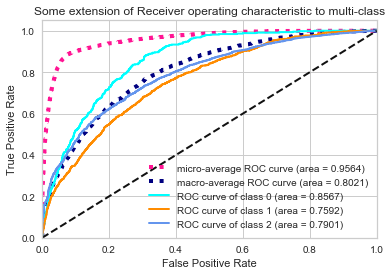

In [21]:
lw = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Feature Importance

In [22]:
# perform permutation importance
results = permutation_importance(sclf,x_train, y_train, scoring='accuracy')
# get importance
importance = results.importances_mean

In [23]:
importancedf = pd.DataFrame(importance)
importancedf.columns=['Score']
x_col=pd.DataFrame(x.columns)
x_col.columns=['Labels']
feature_importance = pd.concat([importancedf,x_col],axis=1)
feature_importance.sort_values('Score',ascending = False, inplace = True)
feature_importancetop10=feature_importance.head(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

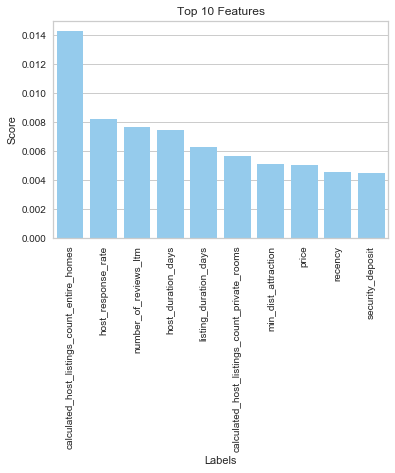

In [24]:
plot1 = sns.barplot(data = feature_importancetop10, x = 'Labels',y = 'Score',
                    order = feature_importancetop10['Labels'], color='lightskyblue').set_title('Top 10 Features')
plt.xticks(rotation=90)

In [25]:
print(feature_importancetop10['Labels'])

20     calculated_host_listings_count_entire_homes
0                               host_response_rate
16                           number_of_reviews_ltm
23                              host_duration_days
24                           listing_duration_days
21    calculated_host_listings_count_private_rooms
39                             min_dist_attraction
9                                            price
40                                         recency
10                                security_deposit
Name: Labels, dtype: object
